In [1]:
import torch
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms import functional as F_t
import torchvision.ops as ops
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_pil_image

from util.box_ops import box_xyxy_to_cxcywh, box_cxcywh_to_xyxy

from scipy.spatial.distance import mahalanobis

from models import build_model
from models.matcher import build_matcher

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns

from collections import Counter

import util.misc as utils

from util import box_ops
from util.misc import NestedTensor
from torch.utils.data import DataLoader

from datasets.torchvision_datasets.open_world import OWDetection
from datasets.coco import make_coco_transforms

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap

from tqdm import tqdm
import json
import os

from adjustText import adjust_text
from args import Args

/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 'TOWOD': ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()

# 모델과 postprocessor 준비
model, _, postprocessors, exemplar_selection, contextual_labeling = build_model(args, mode=args.model_type)
model.to(device)

# 체크포인트 로드 (옵션) / Load checkpoint (optional)
checkpoint = torch.load("./test_model/MOWODB/t1.pth", map_location=device)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

Invalid class range: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
DINO resnet50


/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


running with exemplar_replay_selection
Initialized Contextual Labeling Module


DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [3]:
def get_datasets(args):
    print(args.dataset)

    train_set = args.train_set
    test_set = args.test_set
    dataset_train = OWDetection(args, args.data_root, image_set=args.train_set, transforms=make_coco_transforms(args.train_set), dataset = args.dataset)
    dataset_val = OWDetection(args, args.data_root, image_set=args.test_set, dataset = args.dataset, transforms=make_coco_transforms(args.test_set))

    print(args.train_set)
    print(args.test_set)
    print(dataset_train)
    print(dataset_val)

    return dataset_train, dataset_val

In [4]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'unknown']

In [5]:
dataset_train, dataset_val = get_datasets(args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)

TOWOD
owod_t1_train
owod_all_task_test
Dataset OWDetection
    Number of datapoints: 16551
    Root location: ./data/OWOD
    [['train'], Compose(
    Compose(
)
)]
Dataset OWDetection
    Number of datapoints: 10246
    Root location: ./data/OWOD
    [['test'], Compose(
    Compose(
)
)]


In [78]:
def extract_matched_embeddings(model, matcher, data_loader, device, save_path="matched_embeddings.npz"):
    """
    모든 테스트 이미지에서 GT에 매칭된 query embedding, label, box, score를 추출하고 저장하는 함수
    """
    if os.path.exists(save_path):
        print(f"✅ 이미 존재하는 matched embeddings 파일: {save_path}")
        return

    model.eval()
    all_embeddings = []
    all_labels = []
    all_boxes = [] # cx, cy, w, h
    all_logits = []
    all_obj = []
    all_scores = []

    with torch.no_grad():
        for samples, targets in tqdm(data_loader, desc="Extracting matched queries"):
            samples = samples.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(samples)
            embeddings = outputs["query_embeddings"]  # [B, Q, D]
            pred_boxes = outputs["pred_boxes"]
            pred_logits = outputs["pred_logits"]
            pred_obj = outputs["pred_obj"]  # objectness

            matched_indices = matcher(outputs, targets)

            for b_idx, (src_idx, tgt_idx) in enumerate(matched_indices):
                if len(src_idx) == 0:
                    continue

                # embedding, box, logit 저장
                matched_q = embeddings[b_idx][src_idx]
                matched_boxes = pred_boxes[b_idx][src_idx]
                matched_logits = pred_logits[b_idx][src_idx]
                matched_obj = pred_obj[b_idx][src_idx]

                all_embeddings.append(matched_q.cpu())
                all_boxes.append(matched_boxes.cpu())
                all_logits.append(matched_logits.cpu())
                all_obj.append(matched_obj.cpu())

                obj_prob = torch.exp(-(args.obj_temp/args.hidden_dim) * matched_obj).unsqueeze(-1)  # [M]
                final_score = (obj_prob * matched_logits.sigmoid()).cpu()  # [M]
                all_scores.append(final_score)

                labels_this_batch = targets[b_idx]["labels"][tgt_idx].cpu().tolist()
                all_labels.extend(labels_this_batch)

    # numpy로 변환 및 저장
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    all_labels = np.array(all_labels)
    all_boxes = torch.cat(all_boxes, dim=0).numpy()
    all_logits = torch.cat(all_logits, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()
    all_obj = torch.cat(all_obj, dim=0).numpy()

    np.savez(save_path, embeddings=all_embeddings, labels=all_labels,
             boxes=all_boxes, logits=all_logits, scores=all_scores, obj=all_obj)
    print(f"✅ Matched embeddings 저장 완료: {save_path} | 개수: {len(all_embeddings)}")

    return all_embeddings, all_labels, all_boxes, all_scores, all_obj

def extract_unmatched_embeddings_from_image_with_similarity(
    model, matcher, image_tensor, target, matched_path,
    device, save_path="unmatched_embedding.npz", top_k=10, largest=True, criterion="obj"
):
    model.eval()

    # 1. matched 임베딩 불러오기
    matched_data = np.load(matched_path)
    matched_embeddings = torch.tensor(matched_data["embeddings"]).to(device)  # [M, D]
    matched_labels = matched_data["labels"]  # [M]    

    # 2. 입력 이미지 전처리
    image_tensor = image_tensor.to(device)
    target = [{k: v.to(device) for k, v in target.items()}]

    with torch.no_grad():
        # 3. 모델 추론
        outputs = model(image_tensor)
        query_embeddings = outputs["query_embeddings"][0]  # [Q, D]
        pred_boxes = outputs["pred_boxes"][0]
        pred_logits = outputs["pred_logits"][0]
        pred_obj = outputs["pred_obj"][0]

        obj_prob = torch.exp(-(args.obj_temp/args.hidden_dim) * pred_obj).unsqueeze(-1)
        prob = obj_prob * pred_logits.sigmoid()

        # 4. matcher 기반 matched index 확인
        matched_indices = matcher(outputs, target)[0]
        matched_query_indices = matched_indices[0].cpu().tolist()
        all_indices = set(range(pred_logits.shape[0]))
        unmatched_indices = list(all_indices - set(matched_query_indices))

        if len(unmatched_indices) == 0:
            print("⚠️ unmatched 쿼리가 없습니다.")
            return None, None, None, None

        # 5. 점수 기준 top-k 추출
        topk = min(top_k, len(unmatched_indices))
        if criterion == "obj":
            unmatched_scores = pred_obj[unmatched_indices].cpu()
        elif criterion == "prob":
            unmatched_scores = prob[unmatched_indices].max(dim=-1).values.cpu()
        elif criterion == "cosine":
            unmatched_scores = cosine_similarity(query_embeddings[unmatched_indices].cpu().numpy(), matched_embeddings.cpu().numpy())
            unmatched_scores = torch.tensor(unmatched_scores).max(dim=-1).values.cpu()
        else:
            raise ValueError("criterion은 'obj', 'prob', cosine'만 지원됩니다.")

        unmatched_scores_np = unmatched_scores.numpy()
        sorted_idx = np.argsort(unmatched_scores_np)[::-1] if largest else np.argsort(unmatched_scores_np)
        sorted_idx = sorted_idx.copy()  # 음수 stride 방지

        print(unmatched_scores_np[sorted_idx[:topk]])
        print(prob[unmatched_indices][sorted_idx[:topk]].max(dim=-1).values.cpu().numpy())
        selected_unmatched_indices = [unmatched_indices[i] for i in sorted_idx[:topk]]
        selected_unmatched_embeddings = query_embeddings[selected_unmatched_indices]
        unmatched_embeddings = selected_unmatched_embeddings.cpu().numpy()
        unmatched_boxes = pred_boxes[selected_unmatched_indices].cpu().numpy()
        unmatched_scores = unmatched_scores[sorted_idx[:topk]].numpy().copy()
        unmatched_logits = pred_logits[selected_unmatched_indices].softmax(-1).max(-1).values.cpu().numpy()

        # 7. 저장
        np.savez(save_path,
                 embeddings=unmatched_embeddings,
                 boxes=unmatched_boxes,
                 logits=unmatched_logits,
                 scores=unmatched_scores)

        print(f"✅ Unmatched query (Top-{topk}) + similarity 저장 완료: {save_path}")
        return unmatched_embeddings, unmatched_boxes, unmatched_scores, prob, query_embeddings

def get_sample_from_dataloader(data_loader, index):
    """
    DataLoader 내부의 Dataset에서 특정 인덱스의 데이터를 가져오는 함수

    Args:
        data_loader: PyTorch DataLoader 객체
        index (int): 추출할 데이터 인덱스

    Returns:
        image_tensor: shape (1, 3, H, W)
        target: dict
    """
    dataset = data_loader.dataset
    image, target = dataset[index]

    if isinstance(image, np.ndarray):
        image = to_tensor(image)

    if image.ndim == 3:
        image = image.unsqueeze(0)  # [3, H, W] → [1, 3, H, W]

    return image, target

In [79]:
matcher = build_matcher(args)

In [80]:
save_path="matched_embeddings.npz"

if os.path.exists(save_path):
    print(f"✅ 이미 존재하는 matched embeddings 파일: {save_path}")
    data = np.load(save_path)
else:
    all_embeddings, all_labels, all_boxes, all_scores, all_obj = extract_matched_embeddings(model, matcher, data_loader_val, device, save_path="matched_embeddings.npz")

✅ 이미 존재하는 matched embeddings 파일: matched_embeddings.npz


In [84]:
def experiment_1_combined_visualization(image_tensor, target, matched_path, unmatched_path, method="PCA", class_names=class_names):
    # --- 1. 임베딩 로드 ---
    matched = np.load(matched_path)
    unmatched = np.load(unmatched_path)

    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    matched_embeddings = matched["embeddings"]
    matched_labels = matched["labels"]
    unmatched_embeddings = unmatched["embeddings"]
    unmatched_boxes = unmatched["boxes"]
    unmatched_labels = np.array(["unknown"] * len(unmatched_embeddings))

    # --- 2. 차원 축소 ---
    all_embeddings = np.concatenate([matched_embeddings, unmatched_embeddings], axis=0)
    all_labels = np.concatenate([matched_labels, unmatched_labels], axis=0)
    matched_len = len(matched_embeddings)

    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "T-SNE":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("지원하지 않는 차원 축소 방식입니다.")

    reduced = reducer.fit_transform(all_embeddings)

    # --- 3. 시각화 준비 ---
    image = inv_normalize(image_tensor.squeeze(0).cpu())
    image = to_pil_image(image)
    img_w, img_h = image.size

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # --- 📊 좌측: 임베딩 PCA 시각화 ---
    unique_labels = np.unique(matched_labels)
    cmap = plt.get_cmap("tab20", len(unique_labels))
    label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

    reduced_matched = reduced[:matched_len]
    for i, label in enumerate(unique_labels):
        mask = (matched_labels == label)
        label_name = class_names[label] if class_names else str(label)
        ax1.scatter(reduced_matched[mask, 0], reduced_matched[mask, 1],
                    s=10, alpha=0.5, color=label_to_color[label],
                    label=f"{class_names[i]}")

    reduced_unmatched = reduced[matched_len:]
    ax1.scatter(reduced_unmatched[:, 0], reduced_unmatched[:, 1],
                s=40, c='red', marker='X', label='unmatched')

    texts = [ax1.text(x, y, f"{i}", fontsize=10) for i, (x, y) in enumerate(reduced_unmatched)]
    adjust_text(texts, ax=ax1)

    ax1.set_title(f"{method} | Matched vs. Unmatched Queries")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
    ax1.grid(True)

    # --- 🖼️ 우측: 이미지 + GT + Unmatched 박스 ---
    ax2.imshow(image)

    # GT box
    gt_boxes = target["boxes"].cpu().numpy()
    gt_labels = target["labels"].cpu().numpy()

    for box, label in zip(gt_boxes, gt_labels):
        x_c, y_c, w, h = box
        x1 = (x_c - w / 2) * img_w
        y1 = (y_c - h / 2) * img_h
        w *= img_w
        h *= img_h
        label_name = class_names[label] if class_names else str(label)
        ax2.add_patch(Rectangle((x1, y1), w, h, edgecolor='lime', facecolor='none', linewidth=2))
        ax2.text(x1, y1 + 20, label_name, color='black', fontsize=11,
                 bbox=dict(facecolor='lime', edgecolor='none', alpha=0.6, pad=0.2))

    for i, box in enumerate(unmatched_boxes):
        cx, cy, bw, bh = box

        x1 = max(0, (cx - bw / 2) * img_w)
        y1 = max(0, (cy - bh / 2) * img_h)
        x2 = min(img_w, (cx + bw / 2) * img_w)
        y2 = min(img_h, (cy + bh / 2) * img_h)

        bw = x2 - x1
        bh = y2 - y1

        ax2.add_patch(Rectangle((x1, y1), bw, bh,
                                edgecolor='red', facecolor='none', linewidth=2))
        ax2.text(x1, y1 + 20, f"{i}", color='black', fontsize=11,
                bbox=dict(facecolor='red', edgecolor='none', alpha=0.6, pad=0.2))

    ax2.set_title("GT Boxes (Green) + Unmatched (Red, Indexed)")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return reduced, matched_labels

def compute_unmatched_to_matched_similarity(unmatched_path, matched_path, topk=1, save_path="unmatched_topk_similarity.json"):
    """
    Unmatched 쿼리와 전체 matched 쿼리 간의 Cosine 유사도 기반 top-k 결과를 저장
    → matched 클래스 인덱스도 함께 저장

    저장 형식:
    {
        "Q0": [{"matched_idx": 123, "matched_class": 16, "similarity": 0.92}, ...],
        ...
    }
    """
    # ① 로드
    unmatched = np.load(unmatched_path)
    matched = np.load(matched_path)

    unmatched_embeddings = torch.tensor(unmatched["embeddings"])  # [U, D]
    matched_embeddings = torch.tensor(matched["embeddings"])      # [M, D]
    matched_labels = matched["labels"]                            # [M]
    
    # 클래스 인덱스 문자열로 변환
    matched_labels = matched_labels.tolist() if isinstance(matched_labels, np.ndarray) else list(matched_labels)

    # ② Normalize
    unmatched_norm = F.normalize(unmatched_embeddings, dim=1)  # [U, D]
    matched_norm = F.normalize(matched_embeddings, dim=1)      # [M, D]

    # ③ Cosine 유사도 계산
    similarity_matrix = torch.matmul(unmatched_norm, matched_norm.T)  # [U, M]

    # ④ Top-K 추출
    topk_scores, topk_indices = torch.topk(similarity_matrix, k=topk, dim=1)  # [U, K]

    result = {}
    for i in range(len(unmatched_embeddings)):
        result[f"Q{i}"] = []
        for j in range(topk):
            idx = topk_indices[i][j].item()
            score = topk_scores[i][j].item()
            label = matched_labels[idx]
            result[f"Q{i}"].append({
                "matched_idx": idx,
                "matched_class": int(label),
                "similarity": round(score, 4)
            })

    # ⑤ 저장
    with open(save_path, 'w') as f:
        json.dump(result, f, indent=2)

    print(f"✅ 유사도 계산 완료: Top-{topk} matched 쿼리 저장 → {save_path}")
    return result

def visualize_top1_similar_queries(
    reduced_matched, matched_labels,
    reduced_unmatched,
    similarity_json_path,
    class_names=None,
    figsize=(12, 7)
):
    """
    차원 축소된 matched/unmatched 포인트 간 유사도 시각화

    Args:
        reduced_matched (np.ndarray): [M, 2] 차원 축소된 matched 포인트
        matched_labels (np.ndarray): [M] matched 클래스 인덱스
        reduced_unmatched (np.ndarray): [U, 2] 차원 축소된 unmatched 포인트
        similarity_json_path (str): top-k 유사도 저장 JSON 경로
        class_names (list or dict): 클래스 이름 (선택)
    """

    with open(similarity_json_path, 'r') as f:
        sim_data = json.load(f)

    # 전체 시각화
    plt.figure(figsize=figsize)
    cmap = plt.get_cmap("tab20", len(np.unique(matched_labels)))
    label_to_color = {label: cmap(i) for i, label in enumerate(np.unique(matched_labels))}

    # 🎯 matched 포인트 시각화
    for i, label in enumerate(np.unique(matched_labels)):
        mask = (matched_labels == label)
        points = reduced_matched[mask]
        name = class_names[label] if class_names else f"Class {label}"
        plt.scatter(points[:, 0], points[:, 1], s=10, alpha=0.5,
                    label=f"{name}", color=label_to_color[label])

    # 🔺 unmatched 포인트 시각화
    plt.scatter(reduced_unmatched[:, 0], reduced_unmatched[:, 1],
                s=60, c='red', marker='X', label='Unmatched')

    # 🔗 unmatched → matched 연결선
    for i, (ux, uy) in enumerate(reduced_unmatched):
        top1 = sim_data[f"Q{i}"][0]  # 가장 유사한 matched
        m_idx = top1["matched_idx"]
        sim_score = top1["similarity"]
        cls = top1["matched_class"]
        mx, my = reduced_matched[m_idx]
        plt.plot([ux, mx], [uy, my], 'k--', linewidth=0.8, alpha=0.5)
        plt.text(ux + 0.5, uy, f"Q{i}", fontsize=10, color='black')

    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.grid(True)
    plt.title("Unmatched ↔ Matched Query Similarity (Top-1)")
    plt.tight_layout()
    plt.show()

def run_full_experiment_1_pipeline(model, matcher, data_loader_val, device,
                                   matched_embeddings_path="matched_embeddings.npz",
                                   save_dir="results", test_index=0, topk=1, method="PCA", largest=True, criterion="obj"):
    """
    실험 1 전체 자동화 파이프라인: 차원 축소, 시각화, topk 유사도 바운딩 박스 비교

    Args:
        model: 학습된 OWOD 모델
        matcher: HungarianMatcher 객체
        data_loader_val: 테스트용 DataLoader
        device: torch.device
        matched_embeddings_path: 전체 matched 저장 경로
        save_dir: 결과 저장 디렉토리
        test_index: 시각화 대상 이미지 인덱스
        topk: 가장 유사한 top-k matched 쿼리 시각화
        method: 차원 축소 방법 ("PCA", "T-SNE", "UMAP")
    """
    os.makedirs(save_dir, exist_ok=True)

    # ① 테스트 이미지 한 장 가져오기
    image_tensor, target = get_sample_from_dataloader(data_loader_val, test_index)

    # ② unmatched query 추출
    unmatched_embeddings, unmatched_boxes, unmatched_scores, prob, query_embeddings = extract_unmatched_embeddings_from_image_with_similarity(
        model, matcher, image_tensor, target, matched_embeddings_path, device, save_path=f"{save_dir}/unmatched_embedding.npz", largest=largest, criterion=criterion
    )

    # ③ 차원 축소 + 시각화 + GT + Unmatched 박스 표시
    reduced, matched_labels = experiment_1_combined_visualization(
        image_tensor=image_tensor,
        target=target,
        matched_path=matched_embeddings_path,
        unmatched_path=f"{save_dir}/unmatched_embedding.npz",
        method=method
    )

    # ④ unmatched → matched 쿼리 유사도 계산
    compute_unmatched_to_matched_similarity(
        unmatched_path=f"{save_dir}/unmatched_embedding.npz",
        matched_path=matched_embeddings_path,
        topk=topk,
        save_path=f"{save_dir}/unmatched_topk_similarity.json"
    )

    print(f"🎉 실험 1 전체 파이프라인 완료! 결과 저장 위치: {save_dir}")

    return unmatched_embeddings, unmatched_boxes, unmatched_scores, prob, query_embeddings

[0.7608271  0.7545613  0.7362639  0.71895355 0.7122875  0.69406974
 0.6900216  0.6807514  0.6731279  0.66372913]
[0.7608271  0.7545613  0.7362639  0.71895355 0.7122875  0.69406974
 0.6900216  0.6807514  0.6731279  0.66372913]
✅ Unmatched query (Top-10) + similarity 저장 완료: results/exp1/unmatched_embedding.npz


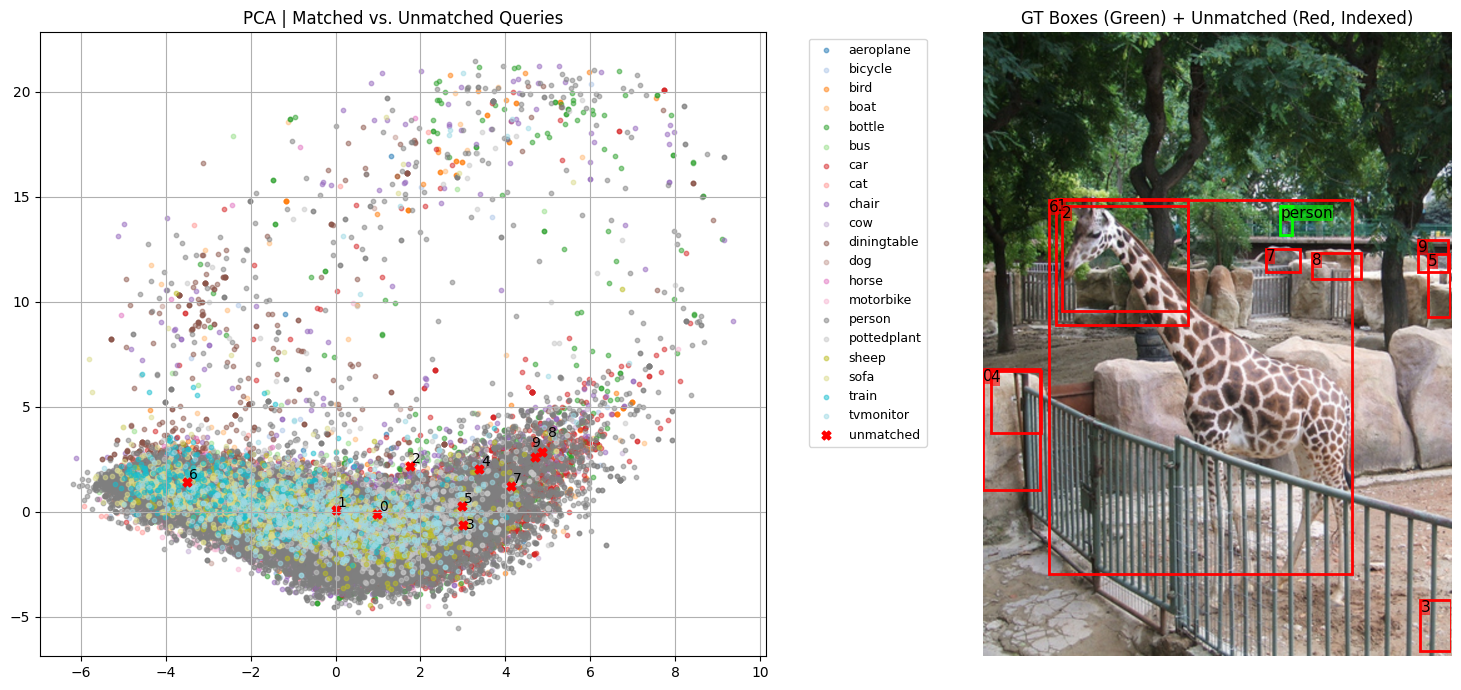

✅ 유사도 계산 완료: Top-10 matched 쿼리 저장 → results/exp1/unmatched_topk_similarity.json
🎉 실험 1 전체 파이프라인 완료! 결과 저장 위치: results/exp1


In [144]:
test_id = 5555
# Top-k
unmatched_embeddings, unmatched_boxes, unmatched_scores, prob, query_embeddings = run_full_experiment_1_pipeline(
    model=model,
    matcher=matcher,
    data_loader_val=data_loader_val,
    device=device,
    test_index=test_id,  # 임의의 테스트 이미지
    method="PCA",
    topk=10,
    save_dir="results/exp1",
    largest=True,
    criterion="prob"  # "obj", "prob", "cosine"
)